In [1]:
import torch
from matplotlib import pyplot as plt

from dataset.FastPatchExtractor import FastPatchDataset, FastPatchExtractor
from operators.noise_operator import NoiseOperator
from patchNR.model import create_NF

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [3]:
patch_size = 6
num_layers = 5
subnet_nodes = 512
weight_path = 'patchNR/patchNR_weights/weights_material.pth'
net = create_NF(num_layers, subnet_nodes, dimension=patch_size**2)
weights = torch.load(weight_path, map_location=DEVICE)
net.load_state_dict(weights['net_state_dict'])
net.to(DEVICE)

ReversibleGraphNet(
  (module_list): ModuleList(
    (0): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=18, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=36, bias=True)
      )
      (subnet2): Sequential(
        (0): Linear(in_features=18, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=36, bias=True)
      )
    )
    (1): PermuteRandom()
    (2): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=18, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=36, bias=True)
      )
      (subnet2): Sequential(
        (0): Lin

In [4]:
train_img_path = './data/material_pt_nr/train.png'
known = FastPatchDataset(train_img_path, patch_size, device=DEVICE)
test_img_path = './data/material_pt_nr/test.png'
unknown = FastPatchDataset(test_img_path, patch_size, device=DEVICE)

In [5]:
def get_regularizer_val(batch):
    pred_inv, log_det_inv = net(batch,rev=True)
    reg = torch.mean(torch.sum(pred_inv**2,dim=1)/2) - torch.mean(log_det_inv)
    return reg

In [6]:
batch_size=40000

In [7]:
known_batch = known.get_batch(batch_size)
know_val = get_regularizer_val(known_batch.to(DEVICE))
unknown_batch = unknown.get_batch(batch_size)
unknown_val = get_regularizer_val(unknown_batch.to(DEVICE))
print(f'Known: {know_val.item()}, Unknown:  {unknown_val.item()}')

Known: -137.80453491210938, Unknown:  -134.50440979003906


Expected behavior is that the regularizer value for the images differs whether the patch is corrupted or not.

In [8]:
operator = NoiseOperator(mean=0, std=0.1, device=DEVICE)
image = known.images[0]
corrupted_image = operator(image)

In [9]:
patch_extractor = FastPatchExtractor(patch_size, device=DEVICE)
batch = patch_extractor.extract(corrupted_image)[:batch_size]
corrupted_val = get_regularizer_val(batch.to(DEVICE))
known_batch_2 = known.patch_extractor.extract(known.images[0])[:batch_size]
know_val_2 = get_regularizer_val(known_batch_2.to(DEVICE))
print(f'Known: {know_val_2.item()}, Corrupted:  {corrupted_val.item()}')

Known: -135.8609619140625, Corrupted:  -135.73085021972656


This is satisfied

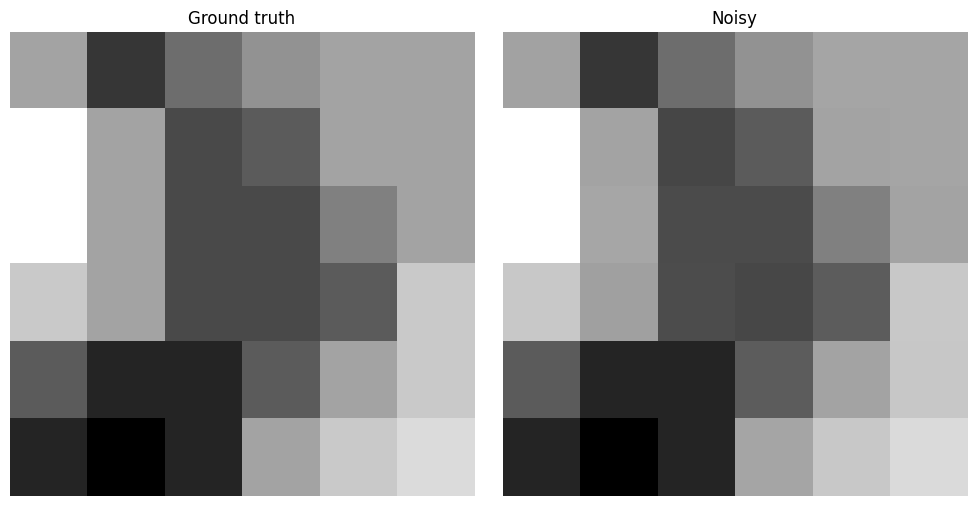

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(torch.reshape(known_batch_2[0].to('cpu'), (patch_size, patch_size)), cmap='gray')
axes[0].set_title('Ground truth')
axes[0].axis('off')
axes[1].imshow(torch.reshape(batch[0].to('cpu'), (patch_size, patch_size)), cmap='gray')
axes[1].set_title('Noisy')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [15]:
def get_reg_for_noise(patch_size, max_noise, step_size=1, device=DEVICE):
    patch_extractor = FastPatchExtractor(patch_size, device=device)
    x, y = [], []
    for i in range(1, max_noise, step_size):
        operator = NoiseOperator(mean=0, std=i, device=device)
        image = known.images[0]
        corrupted_image = operator(image)
        batch = patch_extractor.extract(corrupted_image)[:batch_size]
        corrupted_val = get_regularizer_val(batch.to(device))
        x.append(i)
        y.append(corrupted_val)
    return x, y

In [16]:
x,y = get_reg_for_noise(patch_size, 150, step_size=1, device=DEVICE)

OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 14.58 GiB total capacity; 13.47 GiB already allocated; 37.31 MiB free; 13.77 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
torch.cuda.mem_get_info()

(39124992, 15653470208)